In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import gensim
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from collections import Counter
import gensim.downloader as api

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier,
                              AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, precision_score, confusion_matrix

C:\Users\ADMIN\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
import os
import joblib

# Hàm tải tất cả các model từ một thư mục
def load_all_models(folder_path):
    loaded_models = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith("_model.pkl"):
            model_name = file_name.replace("_model.pkl", "")
            file_path = f"{folder_path}/{file_name}"  # Sử dụng đường dẫn trực tiếp
            loaded_models[model_name] = joblib.load(file_path)
            print(f"Loaded model {model_name}")
    return loaded_models

In [3]:
def load_data(filepath, sep_type, col_1='label', col_2='message', has_header=True):
    """Load dataset from file and return a DataFrame, adjusting for headers."""
    if has_header:
        # Load with the first row as header
        return pd.read_csv(filepath, sep=sep_type, header=0)
    else:
        # Load without headers and assign column names
        return pd.read_csv(filepath, sep=sep_type, header=None, names=[col_1, col_2])

In [4]:
def data_analist(data, corpus):
    df = pd.DataFrame(data)
    print('\n', df.isnull().sum())
    print('\n', df['label'].value_counts())
    print('\n', df.info())
    print(df.columns)
    print('\n', df['label'].value_counts()/len (df)*100)

In [5]:
def preprocess_email(email):
    lemmatizer = WordNetLemmatizer()
    # Loại bỏ ký tự không mong muốn
    email_cleaned = re.sub('[^a-zA-Z]', ' ', email)
    # email_cleaned = re.sub(r'[^a-zA-Z]+', ' ', email.strip())
    
    email_cleaned = email_cleaned.lower().split()
    # Lemmatization
    email_cleaned = [lemmatizer.lemmatize(word, pos='v') for word in email_cleaned if not word in stopwords.words('english')]
    return email_cleaned

In [6]:
def avg_word2vec(words, w2v_model):
    # Apply word2vec
    vectors = [w2v_model[word] for word in words if word in w2v_model.key_to_index]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

In [7]:
def data_preparation(inputCorpus, inputMessage, w2v_model):
    # corpus = [preprocess_email(email) for email in messages['message']]
    X = []
    for i in range(len(inputCorpus)):
        X.append(avg_word2vec(inputCorpus[i], w2v_model))

    # Dependent feature
    y = pd.get_dummies(inputMessage['label']).astype(int)
    y = y.iloc[:, 0].values

    df_list = [pd.DataFrame(X[i].reshape(1, -1)) for i in range(len(X))]
    df = pd.concat(df_list, ignore_index=True)
    df['Output'] = y
    df.dropna(inplace = True)

    # Independent feature

    X = df.drop('Output', axis=1)

    y = df['Output']

    return X, y

In [8]:
def predict_email(email, classifier, w2v_model):
    def isSpam(email):
      email_cleaned = preprocess_email(email)
      email_vector = avg_word2vec(email_cleaned, w2v_model)
      email_vector = email_vector.reshape(1, -1)
      predicted_label = classifier.predict(email_vector)
      print('Spam --' if predicted_label[0] == 0 else 'Ham  --', email)

    results = []

    if(type(email) == str):
        isSpam(email)
      # results.append(isSpam(email))

    elif(type(email) == list):
      for corpus in email:
        isSpam(corpus)

In [9]:
from gensim.models import KeyedVectors

# Use word2vec pre-trained model of Google
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [10]:
model_folder = "best_model"

# Tải lại toàn bộ model
loaded_classify_models = load_all_models(model_folder)

Loaded model AdaBoost
Loaded model Bagging
Loaded model DecisionTree
Loaded model ExtraTrees
Loaded model GradientBoosting
Loaded model KNeighbors
Loaded model LogisticRegression
Loaded model RandomForest
Loaded model SVC
Loaded model XGBr


In [11]:
# loaded_classify_models

In [12]:
knn_model = loaded_classify_models.get("KNeighbors")

In [13]:
predict_email('You have been selected to receive a $10,000 gift card from our exclusive rewards program!', knn_model, w2v_model)

Spam -- You have been selected to receive a $10,000 gift card from our exclusive rewards program!


In [14]:
new_data = pd.read_csv('test/updated_file.csv')

new_corpus = [preprocess_email(email) for email in new_data['message']]

data_analist(new_data, new_corpus)

print("\n")

X_new, y_new = data_preparation(new_corpus, new_data, w2v_model)

X_predict = [text for text in new_data['message']]

accuracy_scores = []
precision_scores = []

for name, classify_model in loaded_classify_models.items():
    y_pred = classify_model.predict(X_new)
    accuracy = accuracy_score(y_new, y_pred)
    precision = precision_score(y_new, y_pred)
    accuracy = round(accuracy, 2)
    precision = round(precision, 2)
    cm = confusion_matrix(y_new, y_pred)
    
    print("\n")
    print("For: ", name)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print(cm)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    # predict_email(X_predict, classify_model, w2v_model)


 message    0
label      0
dtype: int64

 label
ham     500
spam    500
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  1000 non-null   object
 1   label    1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB

 None
Index(['message', 'label'], dtype='object')

 label
ham     50.0
spam    50.0
Name: count, dtype: float64




For:  AdaBoost
Accuracy:  0.73
Precision:  0.84
[[446  54]
 [212 288]]


For:  Bagging
Accuracy:  0.86
Precision:  0.78
[[363 137]
 [  3 497]]


For:  DecisionTree
Accuracy:  0.82
Precision:  0.75
[[338 162]
 [ 19 481]]


For:  ExtraTrees
Accuracy:  0.88
Precision:  0.81
[[386 114]
 [  6 494]]


For:  GradientBoosting
Accuracy:  0.86
Precision:  0.83
[[410  90]
 [ 47 453]]


For:  KNeighbors
Accuracy:  0.55
Precision:  1.0
[[500   0]
 [454  46]]


For:  LogisticRegression
Accuracy:  0.

In [15]:
len(new_corpus)

1000

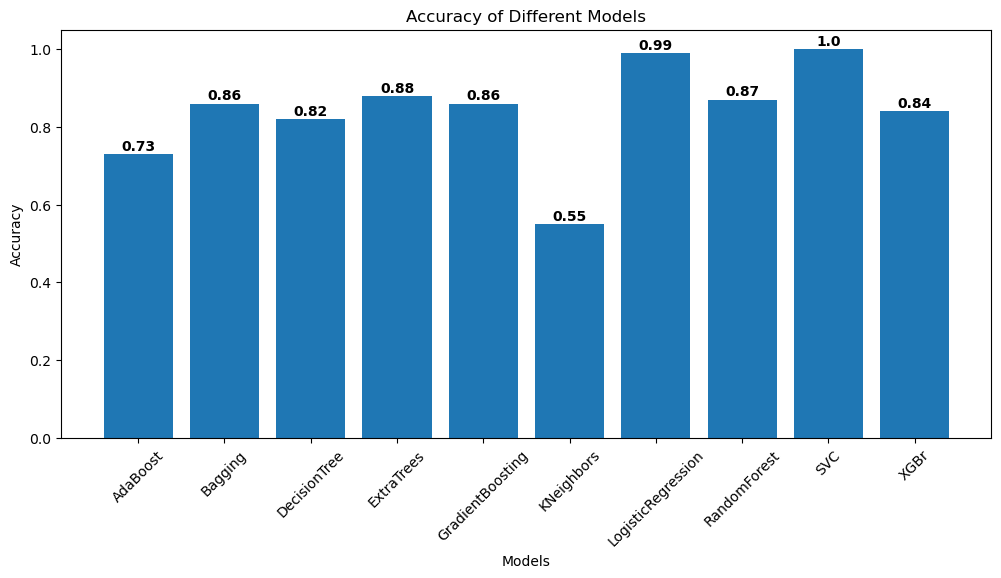

In [16]:
model_names = list(loaded_classify_models.keys())
def plot_model_accuracy(model_names, accuracy_scores):
      # Tạo hình vẽ
      fig, ax = plt.subplots(figsize=(12, 6))

      # Vẽ biểu đồ cột
      ax.bar(model_names, accuracy_scores)

      # Thêm tiêu đề và nhãn trục
      ax.set_title("Accuracy of Different Models")
      ax.set_xlabel("Models")
      ax.set_ylabel("Accuracy")

      # Xoay nhãn trục x để tránh chồng lấn
      plt.xticks(rotation=45)

      # Hiển thị giá trị độ chính xác trên mỗi cột
      for i, v in enumerate(accuracy_scores):
          ax.text(i, v + 0.01, str(round(v, 2)), color='black', ha='center', fontweight='bold')

      # Điều chỉnh khoảng cách giữa các cột
      plt.subplots_adjust(bottom=0.2)

      # Hiển thị biểu đồ
      plt.show()

plot_model_accuracy(model_names, accuracy_scores)

In [17]:
new_data = pd.read_csv('test/test_data2.txt')

new_corpus = [preprocess_email(email) for email in new_data['message']]

data_analist(new_data, new_corpus)

print("\n")

X_new, y_new = data_preparation(new_corpus, new_data, w2v_model)

X_predict = [text for text in new_data['message']]

accuracy_scores = []
precision_scores = []

for name, classify_model in loaded_classify_models.items():
    y_pred = classify_model.predict(X_new)
    accuracy = accuracy_score(y_new, y_pred)
    precision = precision_score(y_new, y_pred)
    accuracy = round(accuracy, 2)
    precision = round(precision, 2)
    cm = confusion_matrix(y_new, y_pred)
    
    print("\n")
    print("For: ", name)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print(cm)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    # predict_email(X_predict, classify_model, w2v_model)


 message    0
label      0
dtype: int64

 label
spam    17
ham     14
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  31 non-null     object
 1   label    31 non-null     object
dtypes: object(2)
memory usage: 628.0+ bytes

 None
Index(['message', 'label'], dtype='object')

 label
spam    54.83871
ham     45.16129
Name: count, dtype: float64




For:  AdaBoost
Accuracy:  0.81
Precision:  0.75
[[13  4]
 [ 2 12]]


For:  Bagging
Accuracy:  0.94
Precision:  0.88
[[15  2]
 [ 0 14]]


For:  DecisionTree
Accuracy:  0.87
Precision:  0.81
[[14  3]
 [ 1 13]]


For:  ExtraTrees
Accuracy:  0.9
Precision:  0.82
[[14  3]
 [ 0 14]]


For:  GradientBoosting
Accuracy:  0.9
Precision:  0.82
[[14  3]
 [ 0 14]]


For:  KNeighbors
Accuracy:  0.58
Precision:  1.0
[[17  0]
 [13  1]]


For:  LogisticRegression
Accuracy:  0.97
Precision:  0.93

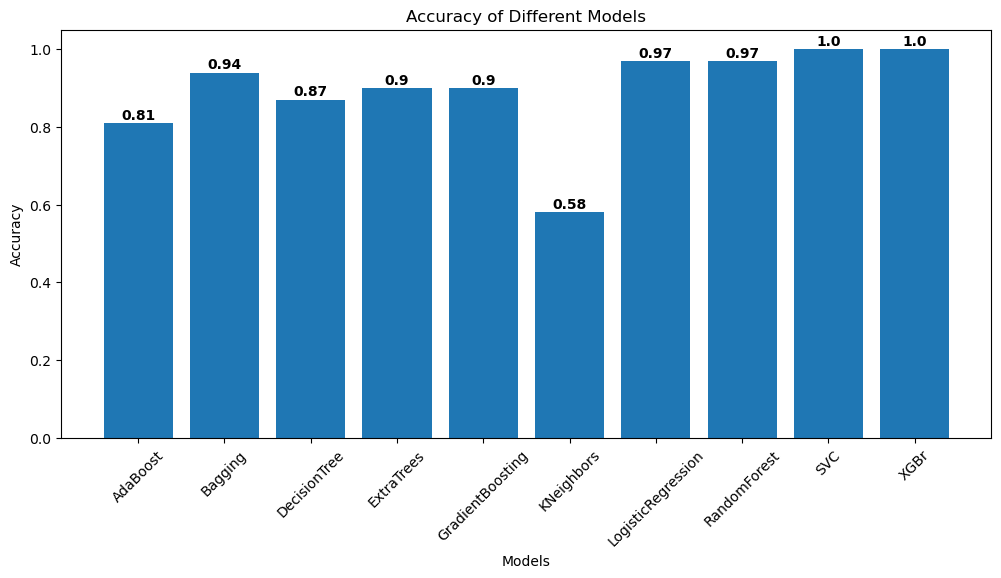

In [18]:
model_names = list(loaded_classify_models.keys())
def plot_model_accuracy(model_names, accuracy_scores):
      # Tạo hình vẽ
      fig, ax = plt.subplots(figsize=(12, 6))

      # Vẽ biểu đồ cột
      ax.bar(model_names, accuracy_scores)

      # Thêm tiêu đề và nhãn trục
      ax.set_title("Accuracy of Different Models")
      ax.set_xlabel("Models")
      ax.set_ylabel("Accuracy")

      # Xoay nhãn trục x để tránh chồng lấn
      plt.xticks(rotation=45)

      # Hiển thị giá trị độ chính xác trên mỗi cột
      for i, v in enumerate(accuracy_scores):
          ax.text(i, v + 0.01, str(round(v, 2)), color='black', ha='center', fontweight='bold')

      # Điều chỉnh khoảng cách giữa các cột
      plt.subplots_adjust(bottom=0.2)

      # Hiển thị biểu đồ
      plt.show()

plot_model_accuracy(model_names, accuracy_scores)

In [19]:
svc_model = loaded_classify_models.get("SVC")

In [20]:
import imaplib
import email
from email.header import decode_header
import re
from bs4 import BeautifulSoup  # Thư viện để xử lý HTML

# Thông tin đăng nhập
username = "tuanbenten24@gmail.com"
password = "uxwg rsjz mzdr amey"

# Kết nối đến Gmail IMAP server
mail = imaplib.IMAP4_SSL("imap.gmail.com")
mail.login(username, password)
mail.select("inbox")

# Tìm kiếm các email
status, messages = mail.search(None, "ALL")
email_ids = messages[0].split()[-20:]

emails = []

# Hàm làm sạch nội dung email
def clean_email_content(content):
    # Loại bỏ các đường link
    content = re.sub(r"http\S+|www\S+|https\S+", "", content, flags=re.MULTILINE)
    # Loại bỏ ký tự xuống dòng và khoảng trắng thừa
    content = re.sub(r'\r\n|\n', ' ', content)
    content = re.sub(r'\s+', ' ', content).strip()
    return content

# Hàm làm sạch và chuyển đổi HTML thành văn bản thuần
def clean_html(content):
    soup = BeautifulSoup(content, "html.parser")  # Chuyển đổi HTML thành đối tượng BeautifulSoup
    return soup.get_text(separator=" ")  # Lấy văn bản thuần từ HTML

# Lặp qua từng email
for email_id in email_ids:
    # Lấy email bằng ID
    res, msg_data = mail.fetch(email_id, "(RFC822)")
    for response_part in msg_data:
        if isinstance(response_part, tuple):
            msg = email.message_from_bytes(response_part[1])

            # Giải mã tiêu đề
            subject, encoding = decode_header(msg["Subject"])[0]
            if isinstance(subject, bytes):
                subject = subject.decode(encoding if encoding else 'utf-8')

            # Lấy và làm sạch nội dung email
            body = ""
            if msg.is_multipart():
                for part in msg.walk():
                    content_type = part.get_content_type()
                    content_disposition = str(part.get("Content-Disposition"))
                    # Chỉ lấy nội dung dạng text/plain hoặc text/html
                    if content_type == "text/plain" and "attachment" not in content_disposition:
                        body += part.get_payload(decode=True).decode()
                    elif content_type == "text/html" and "attachment" not in content_disposition:
                        html_content = part.get_payload(decode=True).decode()
                        body += clean_html(html_content)  # Làm sạch HTML
            else:
                content_type = msg.get_content_type()
                if content_type == "text/plain":
                    body = msg.get_payload(decode=True).decode()
                elif content_type == "text/html":
                    html_content = msg.get_payload(decode=True).decode()
                    body = clean_html(html_content)  # Làm sạch HTML

            # Làm sạch nội dung và lưu email
            clean_body = clean_email_content(body)
            emails.append({"subject": subject, "content": clean_body})

# Đăng xuất
mail.logout()

email_vectors = []

# Tiền xử lý một lần
for email_data in emails:
    cleaned_email = preprocess_email(email_data["content"]) 
    email_vector = avg_word2vec(cleaned_email, w2v_model) 
    email_vectors.append({
        "subject": email_data["subject"],
        "content": email_data["content"],
        "vector": email_vector.reshape(1, -1) 
    })

# Dự đoán nội dung email trên từng mô hình
for name, classify_model in loaded_classify_models.items():
   
    print(f"Results for model: {name}")
    predictions = []
    
    for email_vector_data in email_vectors:
        email_vector = email_vector_data["vector"]  # Lấy vector đã xử lý
        prediction = classify_model.predict(email_vector)
        predictions.append('Spam' if prediction[0] == 0 else 'Ham')

    # In ra dự đoán cho từng email
    for i, email_vector_data in enumerate(email_vectors):
        print("Subject:", email_vector_data["subject"])
        print("Content:", email_vector_data["content"])
        print("Prediction:", predictions[i])  # In ra dự đoán tương ứng
        print("-" * 40)
        print('\n')
    print('\n \n')

Results for model: AdaBoost
Subject: Hypixel - Minecraft Server and Maps Account Confirmation Required
Content: matuy12321, In order to complete your registration at Hypixel - Minecraft Server and Maps, you need to confirm your account by following the link below. Thanks for registering, Hypixel - Minecraft Server and Maps Hypixel - Minecraft Server and Maps Account Confirmation Required Hypixel - Minecraft Server and Maps matuy12321, in order to complete your registration at Hypixel - Minecraft Server and Maps , you need to confirm your account by following the link below. Confirm Account Thanks for registering. Hypixel - Minecraft Server and Maps
Prediction: Spam
----------------------------------------


Subject: 630107 is your Twitter verification code
Content: Twitter Confirm your email address There’s one quick step you need to complete before creating your Twitter account. Let’s make sure this is the right email address for you — please confirm this is the right address to use f